In [2]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

### Przebiegi uczenia dla architektur MLP-LSTM oraz Attention + MLP-LSTM


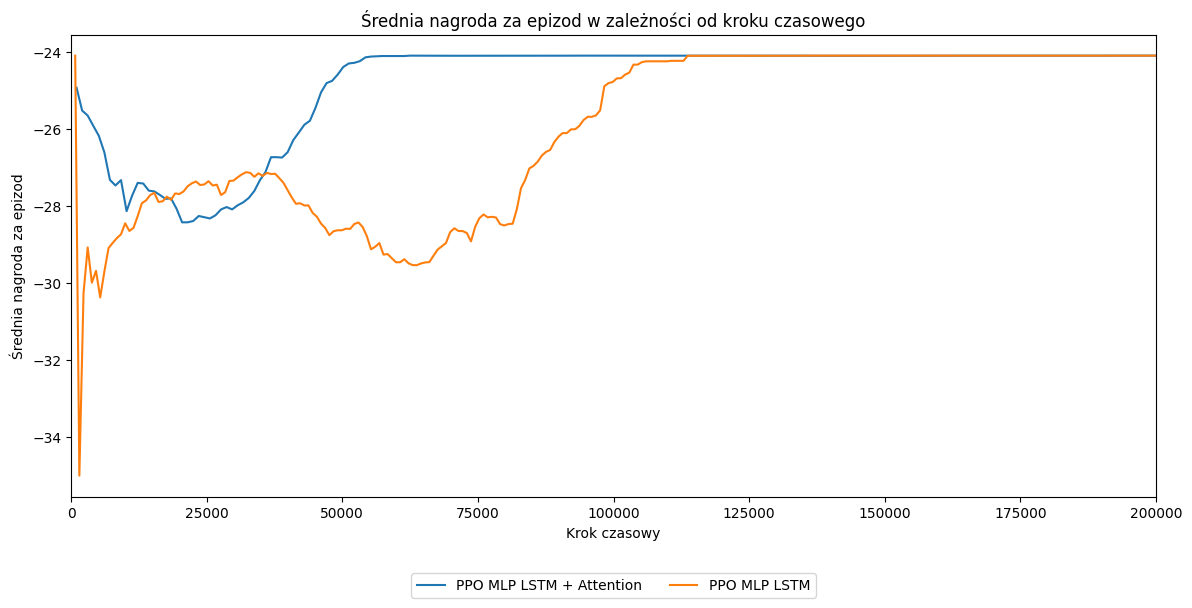

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
# --- GLOBAL COLOR CYCLE SETUP ---
plt.rcParams['axes.prop_cycle'] = cycler(
    color=[
        "#1f77b4",  # blue
        "#ff7f0e",  # orange
        "#2ca02c",  # green
        "#d62728",  # red
        "#9467bd",  # purple
        "#8c564b",  # brown
        "#e377c2",  # pink
        "#7f7f7f",  # gray
        "#bcbd22",  # olive
        "#17becf",  # cyan
    ]
)

TAG = "rollout/ep_rew_mean" \
#"#explained_variance"
#"train/entropy_loss" \
#"entropy_loss" \
#"explained_variance"

models = {
    'PPO MLP LSTM + Attention':   parse_tensorboard(path='./output_malota/RecurrentPPO_171', scalars=[TAG]),
    'PPO MLP LSTM': parse_tensorboard(path='./output_malota/RecurrentPPO_22', scalars=[TAG]),
    
    # add more pairs here
}

#TODO automatic choice models
# models = {
#     'PPO MLP LSTM metryki IG i Attention':   parse_tensorboard(path='./output_malota/RecurrentPPO_155', scalars=[TAG]),
#     'PPO MLP LSTM metryki SPCA i korelacja': parse_tensorboard(path='./output_malota/RecurrentPPO_157', scalars=[TAG]),
#     'PPO MLP LSTM metryki niewybierane przez metody': parse_tensorboard(path='./output_malota/RecurrentPPO_156', scalars=[TAG]),
#     # 'PPO MLP LSTM metryki korelacja': parse_tensorboard(path='./output_malota/RecurrentPPO_157', scalars=[TAG]),
#     # 'PPO MLP LSTM metryki Attention': parse_tensorboard(path='./output_malota/RecurrentPPO_155', scalars=[TAG]),
#     'PPO MLP LSTM wszystkie metryki': parse_tensorboard(path='./output_malota/RecurrentPPO_60', scalars=[TAG]),
    
#     # add more pairs here
# }
# ---- helpers ----

SPAN = 1   # ← EMA smoothness (higher = smoother, more lag)



# ---- helpers ----

def to_df(parsed, tag):
    """Normalize parse_tensorboard() output to a DataFrame with ['step','value']"""
    if isinstance(parsed, pd.DataFrame):
        df = parsed.copy()
        if "tag" in df.columns:
            df = df[df["tag"] == tag]
    elif isinstance(parsed, dict):
        df = parsed[tag].copy()
    else:
        raise TypeError("Unsupported parse_tensorboard output type.")
    if not {"step", "value"}.issubset(df.columns):
        raise ValueError("Expected columns 'step' and 'value' in parsed TF data.")
    return df[["step", "value"]].sort_values("step").reset_index(drop=True)

def step_spacing(df):
    """Robust default step gap for offsetting."""
    gap = df["step"].diff().median()
    if pd.isna(gap) or gap <= 0:
        gap = 1
    return int(gap)

def join_chain(run_dfs):
    """
    Given a list of DataFrames for a chain [df1, df2, ...] (already ordered),
    offset subsequent runs so they continue after the previous.
    Returns concatenated df with ['global_step','value'].
    """
    out = []
    offset = 0
    prev_gap = None

    for i, df in enumerate(run_dfs):
        df = df.copy()
        if i == 0:
            df["global_step"] = df["step"]
            prev_gap = step_spacing(df)
            offset = int(df["global_step"].max()) + prev_gap
        else:
            df["global_step"] = df["step"] + offset
            # keep previous spacing to avoid gaps
            prev_gap = prev_gap if prev_gap is not None else step_spacing(df)
            offset = int(df["global_step"].max()) + prev_gap
        out.append(df[["global_step", "value"]])

    return pd.concat(out, ignore_index=True)

def split_into_chains(models_dict):
    """
    Group model names into chains by a suffix pattern *_N (N >= 2).
    Name without numeric suffix = N=1. Returns dict: base -> [name ordered by N].
    """
    pat = re.compile(r"^(.*?)(?:_(\d+))?$")
    registry = {}  # base -> list of (n, name)

    for name in models_dict:
        m = pat.match(name)
        base = m.group(1) if m else name
        n = int(m.group(2)) if (m and m.group(2)) else 1
        registry.setdefault(base, []).append((n, name))

    chains = {base: [nm for n, nm in sorted(entries, key=lambda x: x[0])]
              for base, entries in registry.items()}
    return chains

def smooth_ema(df, span=SPAN):
    """EMA smoothing of 'value' over 'global_step'."""
    d = df.sort_values("global_step").copy()
    d["smooth"] = d["value"].ewm(span=span, adjust=False).mean()
    return d

# ---- main ----

chains = split_into_chains(models)

all_joined = []          # raw concatenated data
all_joined_smooth = []   # with EMA smoothing

#plt.figure()
plt.figure(figsize=(14, 6))  


for base, names in chains.items():
    # convert each run to df
    run_dfs = []
    for nm in names:
        try:
            run_dfs.append(to_df(models[nm], TAG))
        except Exception as e:
            print(f"Skipping {nm} due to error: {e}")
    if not run_dfs:
        continue

    joined = join_chain(run_dfs)
    joined["chain"] = base
    all_joined.append(joined)

    # Smooth and plot
    sm = smooth_ema(joined, span=SPAN)
    sm["chain"] = base
    all_joined_smooth.append(sm)

    # Optional: faint raw curve in the background
    #plt.plot(joined["global_step"], joined["value"], alpha=0.12, linewidth=1)

    # Smoothed curve
    plt.plot(sm["global_step"], sm["smooth"], label=base)

# Combine to single DataFrames
all_joined = pd.concat(all_joined, ignore_index=True) if all_joined else pd.DataFrame()
all_joined_smooth = pd.concat(all_joined_smooth, ignore_index=True) if all_joined_smooth else pd.DataFrame()



plt.xlabel("Krok czasowy")
plt.ylabel("Średnia nagroda za epizod")
plt.title("Średnia nagroda za epizod w zależności od kroku czasowego")
plt.ylim()   # y-axis cap
plt.xlim(0,200000)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()


# plt.xlabel("Krok czasowy")
# plt.ylabel("Strata entropii")
# plt.title("Strata entropii w zależności od kroku czasowego (EMA)")
# plt.ylim()   # y-axis cap
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
# plt.show()

# plt.xlabel("Krok czasowy")
# plt.ylabel("Wyjaśniana wariancja (0-1)")
# plt.title("Wyjaśniana wariancja w zależności od kroku czasowego (EMA)")
# plt.ylim(-0.5, 1.0)   # y-axis cap
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
# plt.show()
#all_joined       -> columns: ['global_step', 'value', 'chain']
#all_joined_smooth-> columns: ['global_step', 'value', 'smooth', 'chain']



# all_joined columns: ['global_step', 'value', 'chain']
# If you also want original 'step' or run markers inside all_joined, you can add them above.


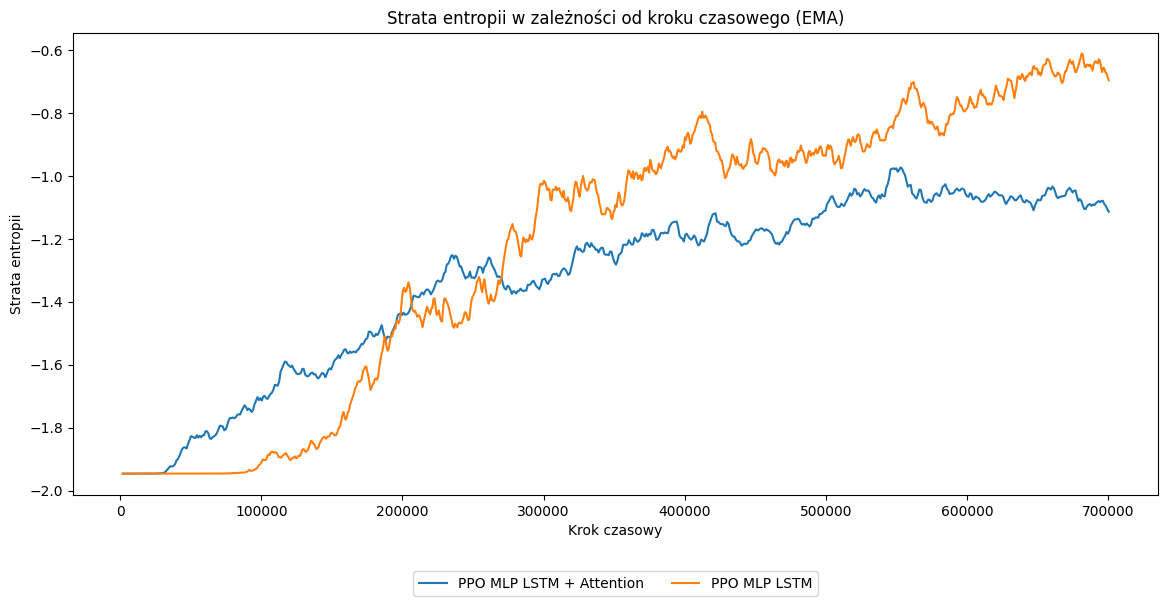

In [5]:

TAG = "train/entropy_loss" 

models = {
    'PPO MLP LSTM + Attention':   parse_tensorboard(path='./output_malota/RecurrentPPO_171', scalars=[TAG]),
    'PPO MLP LSTM': parse_tensorboard(path='./output_malota/RecurrentPPO_22', scalars=[TAG]),
    
    # add more pairs here
}

chains = split_into_chains(models)

all_joined = []          # raw concatenated data
all_joined_smooth = []   # with EMA smoothing

#plt.figure()
plt.figure(figsize=(14, 6))  


for base, names in chains.items():
    # convert each run to df
    run_dfs = []
    for nm in names:
        try:
            run_dfs.append(to_df(models[nm], TAG))
        except Exception as e:
            print(f"Skipping {nm} due to error: {e}")
    if not run_dfs:
        continue

    joined = join_chain(run_dfs)
    joined["chain"] = base
    all_joined.append(joined)

    # Smooth and plot
    sm = smooth_ema(joined, span=SPAN)
    sm["chain"] = base
    all_joined_smooth.append(sm)

    # Optional: faint raw curve in the background
    #plt.plot(joined["global_step"], joined["value"], alpha=0.12, linewidth=1)

    # Smoothed curve
    plt.plot(sm["global_step"], sm["smooth"], label=base)

# Combine to single DataFrames
all_joined = pd.concat(all_joined, ignore_index=True) if all_joined else pd.DataFrame()
all_joined_smooth = pd.concat(all_joined_smooth, ignore_index=True) if all_joined_smooth else pd.DataFrame()



plt.xlabel("Krok czasowy")
plt.ylabel("Strata entropii")
plt.title("Strata entropii w zależności od kroku czasowego (EMA)")
plt.ylim()   # y-axis cap
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

# plt.xlabel("Krok czasowy")
# plt.ylabel("Wyjaśniana wariancja (0-1)")
# plt.title("Wyjaśniana wariancja w zależności od kroku czasowego (EMA)")
# plt.ylim(-0.5, 1.0)   # y-axis cap
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
# plt.show()
#all_joined       -> columns: ['global_step', 'value', 'chain']
#all_joined_smooth-> columns: ['global_step', 'value', 'smooth', 'chain']



# all_joined columns: ['global_step', 'value', 'chain']
# If you also want original 'step' or run markers inside all_joined, you can add them above.


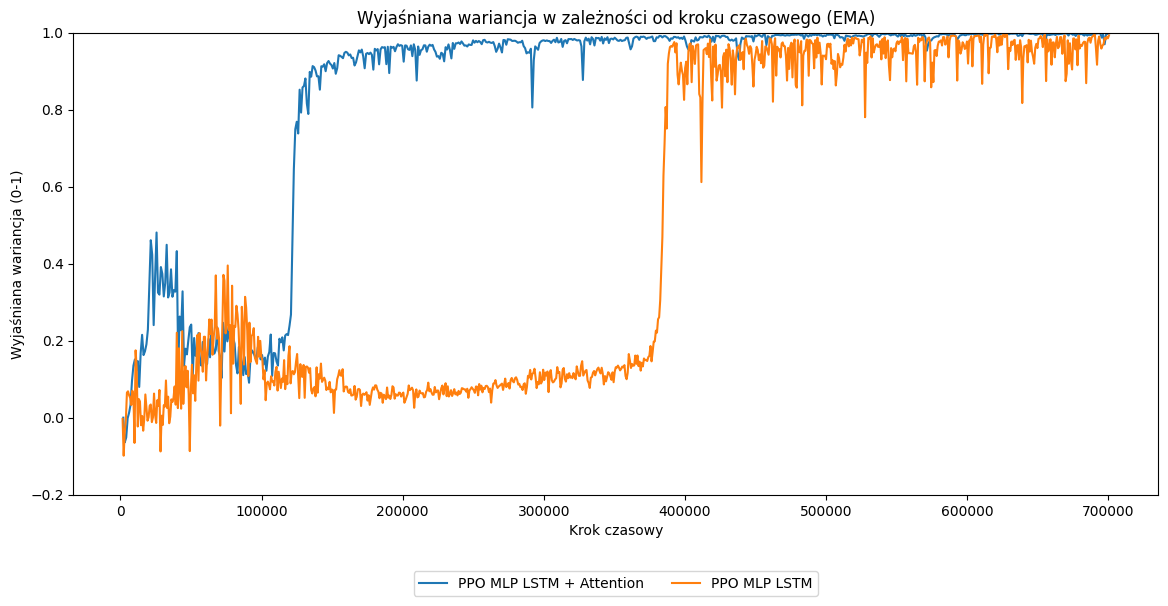

In [7]:

TAG = "train/explained_variance" 

models = {
    'PPO MLP LSTM + Attention':   parse_tensorboard(path='./output_malota/RecurrentPPO_171', scalars=[TAG]),
    'PPO MLP LSTM': parse_tensorboard(path='./output_malota/RecurrentPPO_22', scalars=[TAG]),
    
    # add more pairs here
}

chains = split_into_chains(models)

all_joined = []          # raw concatenated data
all_joined_smooth = []   # with EMA smoothing

#plt.figure()
plt.figure(figsize=(14, 6))  


for base, names in chains.items():
    # convert each run to df
    run_dfs = []
    for nm in names:
        try:
            run_dfs.append(to_df(models[nm], TAG))
        except Exception as e:
            print(f"Skipping {nm} due to error: {e}")
    if not run_dfs:
        continue

    joined = join_chain(run_dfs)
    joined["chain"] = base
    all_joined.append(joined)

    # Smooth and plot
    sm = smooth_ema(joined, span=SPAN)
    sm["chain"] = base
    all_joined_smooth.append(sm)

    # Optional: faint raw curve in the background
    #plt.plot(joined["global_step"], joined["value"], alpha=0.12, linewidth=1)

    # Smoothed curve
    plt.plot(sm["global_step"], sm["smooth"], label=base)

# Combine to single DataFrames
all_joined = pd.concat(all_joined, ignore_index=True) if all_joined else pd.DataFrame()
all_joined_smooth = pd.concat(all_joined_smooth, ignore_index=True) if all_joined_smooth else pd.DataFrame()



# plt.xlabel("Krok czasowy")
# plt.ylabel("Strata entropii")
# plt.title("Strata entropii w zależności od kroku czasowego (EMA)")
# plt.ylim()   # y-axis cap
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
# plt.show()

plt.xlabel("Krok czasowy")
plt.ylabel("Wyjaśniana wariancja (0-1)")
plt.title("Wyjaśniana wariancja w zależności od kroku czasowego (EMA)")
plt.ylim(-0.2, 1.0)   # y-axis cap
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()




# all_joined columns: ['global_step', 'value', 'chain']
# If you also want original 'step' or run markers inside all_joined, you can add them above.
